In [31]:
from abc import ABC, abstractmethod


class BaseModel(ABC):
    def __init__(self, data_loader):
        self.data_loader = data_loader

    @abstractmethod
    def fit(self):
        pass

    @abstractmethod
    def predict(self, X):
        pass

    @abstractmethod
    def evaluate(self):
        pass

    @abstractmethod
    def confusion_matrix(self, plot=False):
        pass

    @abstractmethod
    def cross_validate(self, cv=5):
        pass


class BaseLoader(ABC):
    @abstractmethod
    def load(self):
        pass

    @abstractmethod
    def get_train_data(self):
        pass

    @abstractmethod
    def get_test_data(self):
        pass

    @abstractmethod
    def get_label_mapping(self):
        pass

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


class GrapeTabularDatasetLoader(BaseLoader):
    def __init__(
        self,
        path="tabular/GRAPE_QUALITY.csv",
        target="variety",
        columns_to_drop=["sample_id", "harvest_date", "quality_category"],
        columns_to_convert=["region"],
        test_size=0.2,
        random_state=42,
    ):
        self.path = path
        self.target = target
        self.columns_to_drop = columns_to_drop
        self.columns_to_convert = columns_to_convert
        self.test_size = test_size
        self.random_state = random_state

        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()

        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

        self.load()

    def load(self):
        df = self._load_data()
        df = self._drop_irrelevant_columns(df)
        df = self._encode_categorical_features(df)
        df = self._encode_target(df)
        X, y = self._separate_features_and_target(df)
        X_scaled = self._scale_features(X)
        self._split_train_test(X_scaled, y)

    def _load_data(self):
        return pd.read_csv(self.path)

    def _drop_irrelevant_columns(self, df):
        return df.drop(columns=self.columns_to_drop)

    def _encode_categorical_features(self, df):
        for col in self.columns_to_convert:
            if col in df.columns:
                df[col] = df[col].astype(str)
        return pd.get_dummies(df, columns=self.columns_to_convert)

    def _encode_target(self, df):
        df[self.target] = self.label_encoder.fit_transform(df[self.target])
        return df

    def _separate_features_and_target(self, df):
        X = df.drop(columns=[self.target])
        y = df[self.target]
        return X, y

    def _scale_features(self, X):
        return self.scaler.fit_transform(X)

    def _split_train_test(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )

    def get_train_data(self):
        return self.X_train, self.y_train

    def get_test_data(self):
        return self.X_test, self.y_test

    def get_label_mapping(self):
        return dict(
            zip(
                self.label_encoder.classes_,
                self.label_encoder.transform(self.label_encoder.classes_),
            )
        )

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns


class RandomForestGrapeModel(BaseModel):
    def __init__(self, data_loader, **rf_params):
        super().__init__(data_loader)
        self.model = RandomForestClassifier(**rf_params)

    def fit(self):
        X_train, y_train = self.data_loader.get_train_data()
        self.model.fit(X_train, y_train)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self):
        X_test, y_test = self.data_loader.get_test_data()
        y_pred = self.predict(X_test)
        return {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average="weighted"),
            "recall": recall_score(y_test, y_pred, average="weighted"),
            "f1_score": f1_score(y_test, y_pred, average="weighted"),
        }

    def confusion_matrix(self, plot=False):
        X_test, y_test = self.data_loader.get_test_data()
        y_pred = self.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        if plot:
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.xlabel("Predito")
            plt.ylabel("Real")
            plt.title("Matriz de Confusão")
            plt.show()
        return cm

    def cross_validate(self, cv=5):
        X_train, y_train = self.data_loader.get_train_data()
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(
            self.model, X_train, y_train, cv=skf, scoring="accuracy"
        )
        return {
            "cv_accuracy_mean": scores.mean(),
            "cv_accuracy_std": scores.std(),
            "cv_scores": scores,
        }

{'accuracy': 0.155, 'precision': 0.1464370767290272, 'recall': 0.155, 'f1_score': 0.14615560829716145}


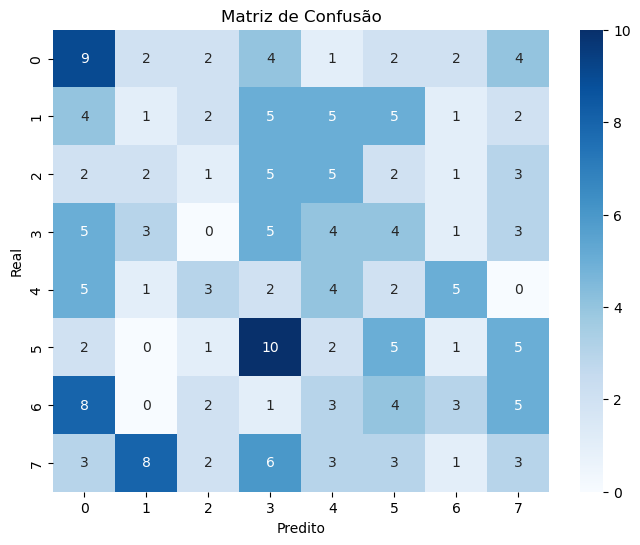

{'cv_accuracy_mean': np.float64(0.14375), 'cv_accuracy_std': np.float64(0.013110110602126893), 'cv_scores': array([0.13125, 0.15   , 0.15625, 0.125  , 0.15625])}


In [ ]:
loader = GrapeTabularDatasetLoader(path="./GRAPE_QUALITY.csv")

model = RandomForestGrapeModel(loader, n_estimators=100)
model.fit()
metrics = model.evaluate()
print(metrics)
model.confusion_matrix(plot=True)
print(model.cross_validate(cv=5))